In [1]:
from typing import Tuple
import pandas as pd

import torch
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

from vae import VariationAutoencoderModule, WassersteinLoss, MultiCategoricalLoss
from data import UpdrsDataQoL, UpdrsDataModule

## Fit the model

In [ ]:
NAME = "updrs_qol_vae_new"

data = UpdrsDataQoL(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/updrs_amp.csv"
)
data_module = UpdrsDataModule(
    data,
    percentage_subjects_in_valid_dataset=0.2,
    batch_size=512,
)
print(len(data_module.train_dataloader()))
print(len(data_module.val_dataloader()))

reconstruction_loss = MultiCategoricalLoss(
    n_values=len(UpdrsDataQoL.COLUMNS),
    n_classes=5,
    is_categorical=False,
    is_ordinal=True,
    weight=data_module.calculate_class_weights().to("cuda"),
)
#generative_loss = KullbackLeiblerLoss(beta=1.0)
generative_loss = WassersteinLoss(reg_weight=100, kernel_type="imq", z_var=2.0)
model = VariationAutoencoderModule(
    reconstruction_loss, generative_loss, [64, 48, 32, 16], patience=80, learning_rate=1e-3, dropout=0.05
)
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename=NAME,
    save_top_k=1,
    verbose=True,
    monitor="val_concordance",
    mode="max",
)
early_stopping = EarlyStopping(monitor="val_concordance", patience=120, mode="max")
logger = TensorBoardLogger("logs", name=NAME)

# Initialize the PyTorch Lightning trainer
trainer = L.Trainer(
    max_epochs=1000, callbacks=[early_stopping], logger=logger, log_every_n_steps=6
)

trainer.fit(model, data_module)

## Evaluate the model

In [4]:
model = VariationAutoencoderModule.load_from_checkpoint(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/src/checkpoints_val_loss/updrs_qol_optuna_val_loss_52.ckpt"
).model.eval()

### Check its applicability for PDQ prediction

In [7]:
MAX_SCORES = {
    "Mobility": 40,
    "Daily living": 24,
    "Emotion": 24,
    "Stigmatization": 16,
    "Social support": 12,
    "Cognition": 16,
    "Communication": 12,
    "Bodily discomfort": 12,
}
TARGET_COLUMNS = list(MAX_SCORES.keys())

X_amp = pd.read_csv("../data/pdq_amp.csv", na_values="Unknown")
X_amp.columns = X_amp.columns.str.replace("ADL", "Daily living", regex=False)
X_amp.columns = X_amp.columns.str.replace("Stigma", "Stigmatization", regex=False)
X_amp.columns = X_amp.columns.str.replace("Social", "Social support", regex=False)
X_amp.columns = X_amp.columns.str.replace(
    "Discomfort", "Bodily discomfort", regex=False
)

value_map = {
    "Never": 0,
    "Occasionally": 1,
    "Sometimes": 2,
    "Often": 3,
    "Always or cannot do at all": 4,
}

# Convert relevant columns using the map to numerical values
for col in X_amp.columns:
    if col.startswith("PDQ39"):
        X_amp[col] = X_amp[col].map(value_map).astype(pd.Int64Dtype())

for key, value in MAX_SCORES.items():
    selected_columns = X_amp.filter(like=key)
    assert len(selected_columns.columns) * 4 == value
    X_amp[key] = selected_columns.sum(axis=1, skipna=False)
    X_amp[key] = (X_amp[key] * 100) / value
    X_amp = X_amp.drop(columns=selected_columns.columns)

# Cast the UPDRS scoresx
for col in X_amp.columns:
    if col.startswith("UPDRS"):
        X_amp[col] = X_amp[col].astype(pd.Int64Dtype())
X_amp = X_amp.drop(columns=["MoCA", "UPDRS I", "UPDRS II", "UPDRS III"])

UPDRS_I_columns = X_amp.filter(like="UPDRS 1.")
UPDRS_II_columns = X_amp.filter(like="UPDRS 2.")
UPDRS_IV_columns = X_amp.filter(like="UPDRS 4.")

X_amp["PDQ"] = X_amp[TARGET_COLUMNS].mean(axis=1)
X_amp = X_amp.dropna(subset=["PDQ"])

y_amp = pd.DataFrame.from_dict({
    "UPDRS I": (UPDRS_I_columns.sum(axis=1, skipna=False) / (len(UPDRS_I_columns.columns) * 4)) * 100,
    "UPDRS II": (UPDRS_II_columns.sum(axis=1, skipna=False) / (len(UPDRS_II_columns.columns) * 4)) * 100,
    "UPDRS IV": (UPDRS_IV_columns.sum(axis=1, skipna=False) / (len(UPDRS_IV_columns.columns) * 4)) * 100,
    "PDQ": X_amp["PDQ"]
})
y_amp[TARGET_COLUMNS] = X_amp[TARGET_COLUMNS]

X_amp = X_amp.drop(columns=TARGET_COLUMNS + ["PDQ"])

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, mean_absolute_error
import seaborn as sns

X = X_amp[[column for column in X_amp.columns if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.")]].to_numpy().astype(float)
y = y_amp["PDQ"].to_numpy()

X_feature = model(torch.tensor(X, dtype=torch.float32).to("cuda")).z_dist.loc.cpu().detach().numpy()

folds = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
representation_results = []
for name, regressor in {
    "Linear": LinearRegression(),
    "Ensemble": HistGradientBoostingRegressor(loss="absolute_error")
}.items():
    for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
        regressor.fit(X_feature[train_index], y[train_index])
        representation_results.append(pd.DataFrame({"PDQ: Ground truth": y[test_index], "PDQ: Prediction": regressor.predict(X_feature[test_index]), "Method": name, "Fold": fold}))

representation_results = pd.concat(representation_results)
representation_results["Input"] = "Representation"

representation_results

,PDQ: Ground truth,PDQ: Prediction,Method,Fold,Input
0,41.875000,31.195389,Linear,0,Representation
1,29.062500,27.607159,Linear,0,Representation
2,11.666667,14.342444,Linear,0,Representation
3,42.395833,45.924252,Linear,0,Representation
4,34.739583,29.950016,Linear,0,Representation
...,...,...,...,...,...
222,9.375000,14.451586,Ensemble,9,Representation
223,20.937500,14.451586,Ensemble,9,Representation
224,9.880952,10.636643,Ensemble,9,Representation
225,12.864583,8.162064,Ensemble,9,Representation


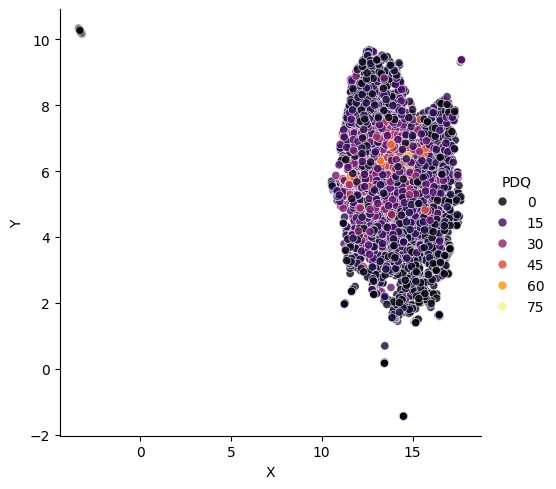

In [8]:
from umap import UMAP

#projected_data = pd.DataFrame.from_records(UMAP(n_neighbors=25, min_dist=0.01, n_components=2, target_metric="l1").fit_transform(X_feature, y=df_amp[["UPDRS I", "UPDRS II"]].sum(axis=1).to_numpy()), columns=["X", "Y"])

projected_data = pd.DataFrame.from_records(UMAP(n_neighbors=10, min_dist=0.1, n_components=2).fit_transform(X_feature), columns=["X", "Y"])
projected_data["PDQ"] = y   
sns.relplot(data=projected_data, x="X", y="Y", hue="PDQ", alpha=0.8, palette="inferno")

In [9]:
X_amp.columns

Index(['Participant', 'Visit ID', 'Age (Diagnosis)', 'Age', 'Diagnosis',
       'Study', 'Surgery', 'Medication', 'Sex', 'Education', 'UPDRS 1.1',
       'UPDRS 1.2', 'UPDRS 1.3', 'UPDRS 1.4', 'UPDRS 1.5', 'UPDRS 1.6',
       'UPDRS 1.7', 'UPDRS 1.8', 'UPDRS 1.9', 'UPDRS 1.10', 'UPDRS 1.11',
       'UPDRS 1.12', 'UPDRS 1.13', 'UPDRS 2.1', 'UPDRS 2.2', 'UPDRS 2.3',
       'UPDRS 2.4', 'UPDRS 2.5', 'UPDRS 2.6', 'UPDRS 2.7', 'UPDRS 2.8',
       'UPDRS 2.9', 'UPDRS 2.10', 'UPDRS 2.11', 'UPDRS 2.12', 'UPDRS 2.13',
       'Hoehn and Yahr', 'UPDRS 3.1', 'UPDRS 3.2', 'UPDRS 3.3a', 'UPDRS 3.3b',
       'UPDRS 3.3c', 'UPDRS 3.3d', 'UPDRS 3.3e', 'UPDRS 3.4a', 'UPDRS 3.4b',
       'UPDRS 3.5a', 'UPDRS 3.5b', 'UPDRS 3.6a', 'UPDRS 3.6b', 'UPDRS 3.7a',
       'UPDRS 3.7b', 'UPDRS 3.8a', 'UPDRS 3.8b', 'UPDRS 3.9', 'UPDRS 3.10',
       'UPDRS 3.11', 'UPDRS 3.12', 'UPDRS 3.13', 'UPDRS 3.14', 'UPDRS 3.15a',
       'UPDRS 3.15b', 'UPDRS 3.16a', 'UPDRS 3.16b', 'UPDRS 3.17a',
       'UPDRS 3.17b', 'UPDRS 3.

In [27]:
def calculate_predictions(df_amp: pd.DataFrame, columns_individual, columns_scores, input_type: str) -> pd.DataFrame:
    X = df_amp[columns_individual]
    y = df_amp["PDQ"].to_numpy()
    folds = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)

    results = []

    # Check the baseline condition on scores
    for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
        regressor = LinearRegression()
        regressor.fit(df_amp[columns_scores].iloc[train_index], y[train_index])
        results.append(pd.DataFrame({"PDQ: Ground truth": y[test_index], "PDQ: Prediction": regressor.predict(df_amp[columns_scores].iloc[test_index]), "Method": "Linear (score)", "Fold": fold}))
    
    # Use the individual values
    for name, regressor in {
        "Linear": LinearRegression(),
        "Ensemble": HistGradientBoostingRegressor(loss="absolute_error")
    }.items():
        for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
            regressor.fit(X.iloc[train_index], y[train_index])
            results.append(pd.DataFrame({"PDQ: Ground truth": y[test_index], "PDQ: Prediction": regressor.predict(X.iloc[test_index]), "Method": name, "Fold": fold}))
    
    result = pd.concat(results)
    result["Input"] = input_type
    return result

results_updrs_i = calculate_predictions(X_amp, [column for column in X_amp.columns if column.startswith("UPDRS 1.")], ["UPDRS I"], "UPDRS I only")
results_updrs_ii = calculate_predictions(X_amp, [column for column in X_amp.columns if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.")], ["UPDRS I", "UPDRS II"], "UPDRS I and II")
results_updrs_iv = calculate_predictions(X_amp, [column for column in X_amp.columns if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.") or column.startswith("UPDRS 4.")], ["UPDRS I", "UPDRS II", "UPDRS IV"], "UPDRS I, II and IV")
result = pd.concat([results_updrs_i, results_updrs_ii, results_updrs_iv, representation_results])

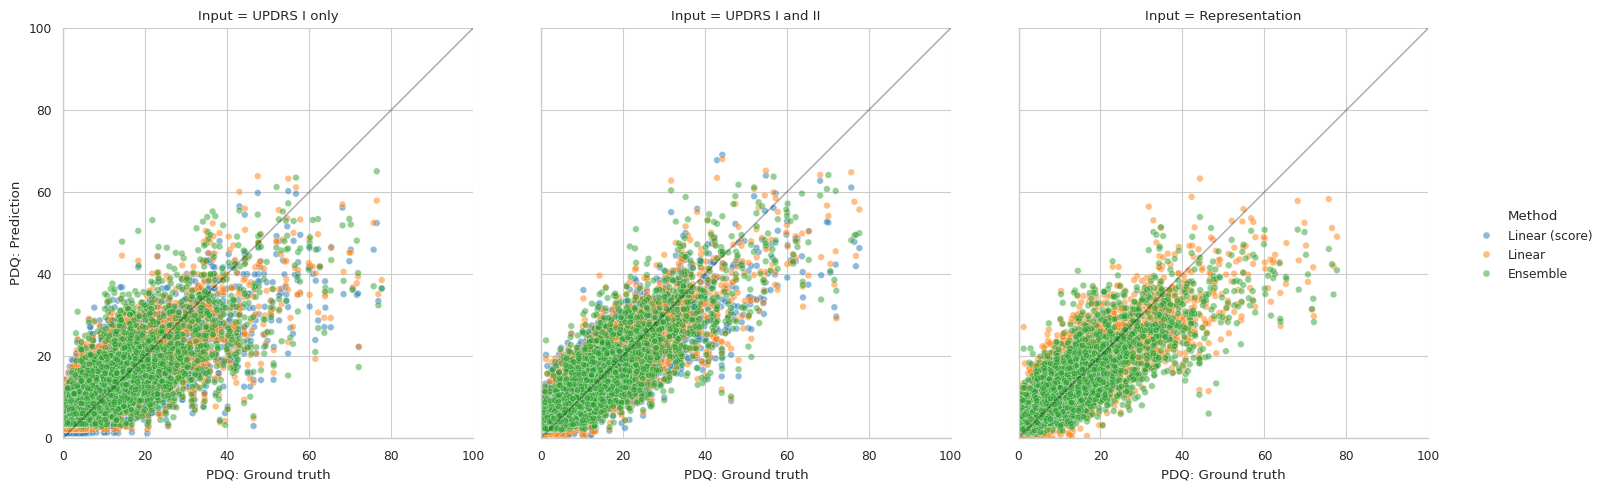

In [28]:
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    grid = sns.relplot(data=result, x="PDQ: Ground truth", y="PDQ: Prediction", hue="Method", col="Input", alpha=0.5)
    grid.set(xlim=(0, 100), ylim=(0, 100), aspect="equal")
    for ax in grid.axes.flatten():
        ax.plot([0, 100], [0, 100], color="black", linestyle="-", alpha=0.3)

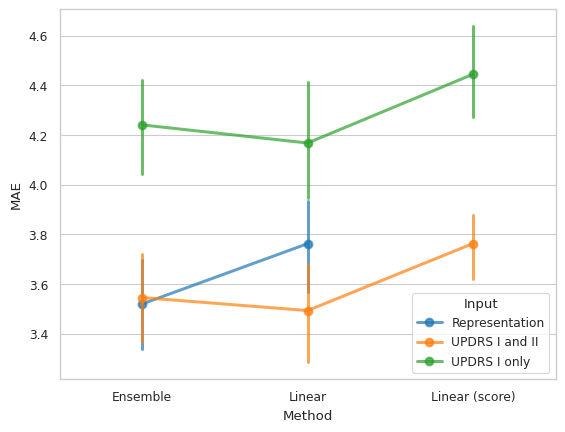

In [29]:
median_absolute_error_agg = []
for input, input_data in result.groupby("Input"):
    for name, method_data in input_data.groupby("Method"):
        folds = method_data.groupby("Fold")
        median_absolute_error_agg.append(
            pd.DataFrame.from_dict({"Method": name, "Input": input, "MAE": [median_absolute_error(y_true=fold['PDQ: Ground truth'], y_pred=fold['PDQ: Prediction']) for _, fold in folds], "Fold": range(len(folds))})
        )
median_absolute_error_agg = pd.concat(median_absolute_error_agg)

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.pointplot(data=median_absolute_error_agg, x="Method", y="MAE", hue="Input", alpha=0.7)

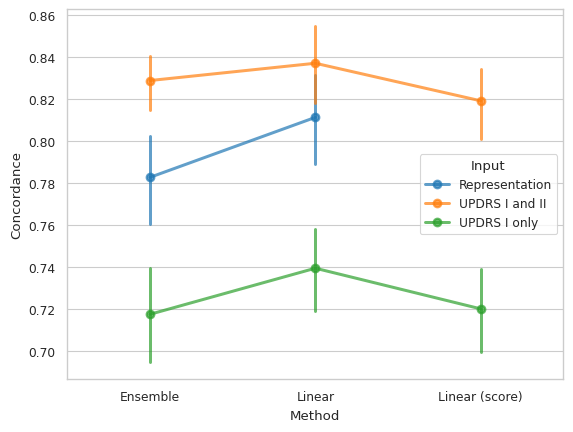

In [30]:
from torchmetrics.functional import concordance_corrcoef

concordance_agg = []
for (method, input_data), data in result.groupby(["Method", "Input"]):
    concordance = [float(concordance_corrcoef(preds=torch.tensor(fold["PDQ: Prediction"].to_numpy()), target=torch.tensor(fold["PDQ: Ground truth"].to_numpy()))) for _, fold in data.groupby("Fold")]
    concordance_agg.append(
        pd.DataFrame.from_dict({"Method": method, "Input": input_data, "Concordance": concordance })
    )

concordance_agg = pd.concat(concordance_agg)
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.pointplot(data=concordance_agg, x="Method", y="Concordance", hue="Input", alpha=0.7)

### Calculate values on test dataset

In [10]:
def load_testdata(path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    data = pd.read_csv(
        path,
        sep=",",
        na_values=[
            "Keine_Angabe",
            "Nicht_durchgeführt",
            "Keine_Angaben",
            "Keine_angabe",
        ],
    )
    pdq_columns = [column for column in data.columns if column.startswith("PDQ39 ")]
    updrs_columns = [
        column
        for column in data.columns
        if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.")
    ]
    data = data[pdq_columns + updrs_columns].dropna().reset_index(drop=True)
    return data[updrs_columns], data[pdq_columns]


test_updrs, test_pdq = load_testdata(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv"
)

ground_truth = next(iter(data_module.val_dataloader()))
reconstruction = model(ground_truth.to("cuda")).x_recon
ground_truth_sum = ground_truth.sum(axis=-1).to("cuda")
reconstruction_sum = reconstruction.sum(axis=-1)

print(
    F.l1_loss(
        input=ground_truth.to("cuda"),
        target=model(ground_truth.to("cuda")).x_recon,
        reduction="none",
    )
    .sum(axis=-1)
    .mean()
    / (ground_truth.shape[-1])
)
print(
    (
        (ground_truth.to("cuda") != model(ground_truth.to("cuda")).x_recon).sum(axis=-1)
        / ground_truth.shape[-1]
    ).median()
)
print(
    torchmetrics.functional.concordance_corrcoef(
        target=ground_truth_sum.to(torch.float),
        preds=reconstruction_sum.to(torch.float),
    )
)

tensor(0.0645, device='cuda:0')
tensor(0.0385, device='cuda:0')
tensor([0.9762], device='cuda:0')


In [9]:
reconstruction

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0')